### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

"""
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb
"""

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = 'C:/Users/Ishani Dixit/Downloads/suyash/Alzheimer_Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'C:/Users/Ishani Dixit/Downloads/suyash/Alzheimer_Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.97s/it]


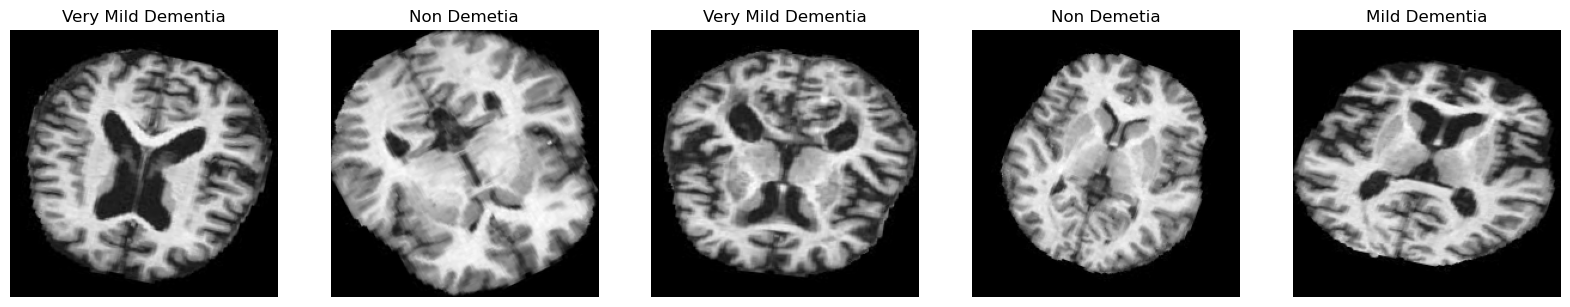

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [6]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [7]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [9]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [10]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [11]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [14]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.0086 - auc: 0.8408
Epoch 1: val_auc improved from 0.68875 to 0.77100, saving model to .\best_weights.hdf5
33/33 [==============================] - 375s 11s/step - loss: 1.0086 - auc: 0.8408 - val_loss: 1.7804 - val_auc: 0.7710
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.9306 - auc: 0.8586 
Epoch 2: val_auc improved from 0.77100 to 0.77524, saving model to .\best_weights.hdf5
33/33 [==============================] - 701s 22s/step - loss: 0.9306 - auc: 0.8586 - val_loss: 1.3303 - val_auc: 0.7752
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.8937 - auc: 0.8682
Epoch 3: val_auc improved from 0.77524 to 0.80908, saving model to .\best_weights.hdf5
33/33 [==============================] - 356s 11s/step - loss: 0.8937 - auc: 0.8682 - val_loss: 1.1869 - val_auc: 0.8091
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.8047 - auc: 0.8867
Epoch 4: val_au

33/33 [==============================] - 336s 10s/step - loss: 0.5359 - auc: 0.9472 - val_loss: 1.5613 - val_auc: 0.8046
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.5196 - auc: 0.9501
Epoch 32: val_auc did not improve from 0.85315
33/33 [==============================] - 338s 10s/step - loss: 0.5196 - auc: 0.9501 - val_loss: 1.2835 - val_auc: 0.8264
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.5266 - auc: 0.9493
Epoch 33: val_auc improved from 0.85315 to 0.86043, saving model to .\best_weights.hdf5
33/33 [==============================] - 346s 11s/step - loss: 0.5266 - auc: 0.9493 - val_loss: 1.1023 - val_auc: 0.8604
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.5037 - auc: 0.9535
Epoch 34: val_auc did not improve from 0.86043
33/33 [==============================] - 343s 10s/step - loss: 0.5037 - auc: 0.9535 - val_loss: 1.3798 - val_auc: 0.8224
Epoch 35/100
33/33 [==============================] - ETA: 0s

Epoch 63/100
33/33 [==============================] - ETA: 0s - loss: 0.4199 - auc: 0.9674
Epoch 63: val_auc did not improve from 0.87374
33/33 [==============================] - 332s 10s/step - loss: 0.4199 - auc: 0.9674 - val_loss: 1.1768 - val_auc: 0.8515
Epoch 63: early stopping


### MODEL EVALUATION

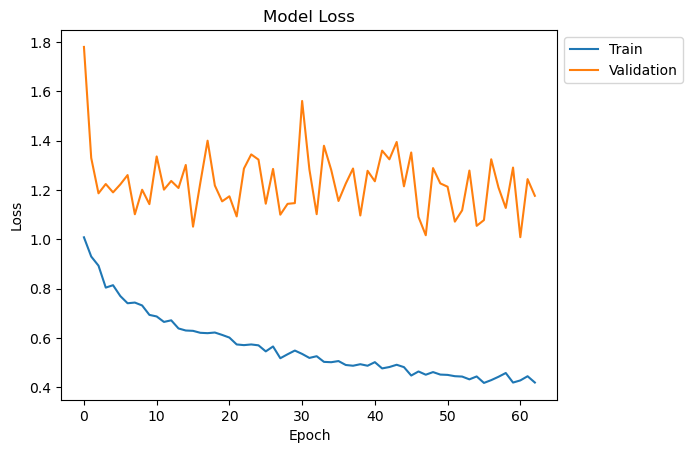

In [15]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

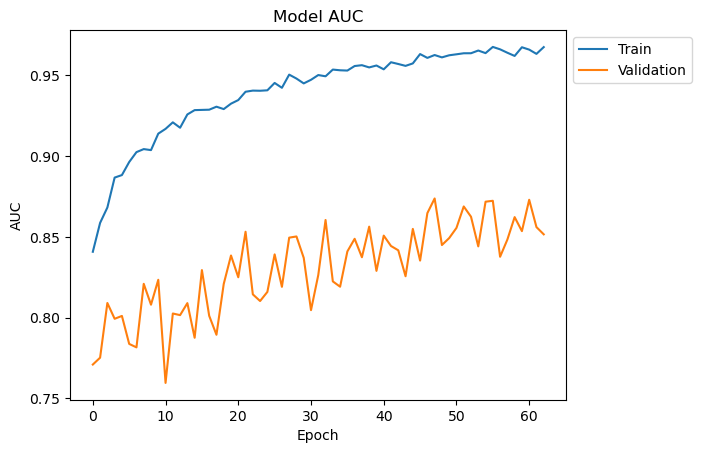

In [16]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'C:/Users/Ishani Dixit/Downloads/suyash/Alzheimer_Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [18]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 59s 6s/step - loss: 1.0258 - auc: 0.8918


[1.0257925987243652, 0.8917968273162842]

1/1 [==============================] - 0s 128ms/step
[[2.29359887e-09 9.99999998e-01]]
[[2.2935989e-09 2.4602656e-15 9.9302906e-01 6.9709118e-03]]
{(0, 0): 2.2935989e-09, (0, 1): 2.4602656e-15, (0, 2): 0.99302906, (0, 3): 0.0069709118}
(0, 2)
NonDemented


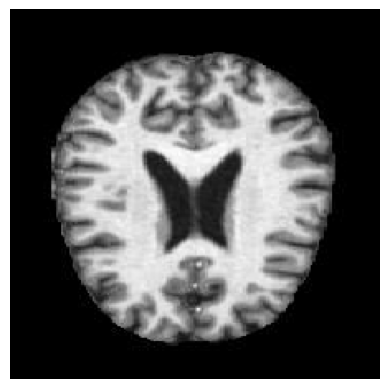

In [60]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

def predict_prob(number):
    return [number[0],1-number[0]]

img = load_img('C:/Users/Ishani Dixit/Downloads/suyash/Alzheimer_Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
#probability = round(np.max(model.predict_proba(img)*100),2)
y_prob = np.array(list(map(predict_prob, model.predict(img))))

#print(probability, '% chances are there that the image is',idc[answer[0]])

print(y_prob)
print(answer)

d = dict(np.ndenumerate(answer))
print(d)

Keymax = max(d, key= lambda x: d[x])
print(Keymax)

print(idc[int(Keymax[1])])

1/1 [==============================] - 0s 129ms/step
[[0.95758957 0.04241043]]
{(0, 0): 0.95758957, (0, 1): 2.9002713e-05, (0, 2): 0.024129117, (0, 3): 0.018252319}
(0, 0)
MildDemented


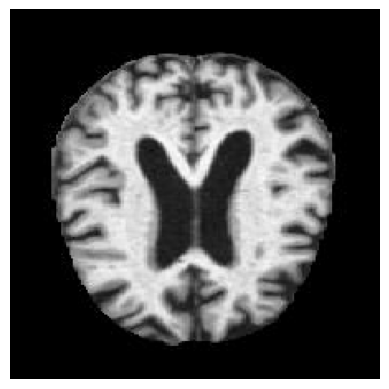

In [59]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('C:/Users/Ishani Dixit/Downloads/suyash/Alzheimer_Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
#probability = round(np.max(model.predict_proba(img)*100),2)

#print(probability, '% chances are there that the image is',idc[answer[0]])

y_prob = np.array(list(map(predict_prob, model.predict(img))))

#print(probability, '% chances are there that the image is',idc[answer[0]])

print(y_prob)
d = dict(np.ndenumerate(answer))
print(d)

Keymax = max(d, key= lambda x: d[x])
print(Keymax)

print(idc[int(Keymax[1])])

1/1 [==============================] - 0s 138ms/step
[[0.00423353 0.99576647]]
[[4.2335335e-03 9.9524915e-01 1.9676542e-04 3.2051414e-04]]
{(0, 0): 0.0042335335, (0, 1): 0.99524915, (0, 2): 0.00019676542, (0, 3): 0.00032051414}
(0, 1)
ModerateDemented


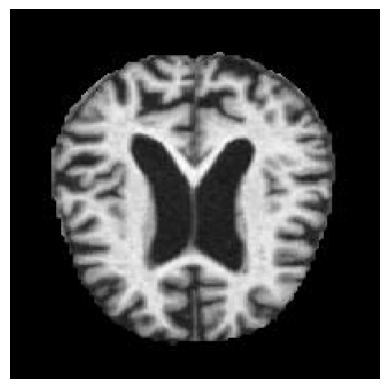

In [58]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('C:/Users/Ishani Dixit/Downloads/suyash/Alzheimer_Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
#probability = round(np.max(model.predict_proba(img)*100),2)

#print(probability, '% chances are there that the image is',idc[answer[0]])

y_prob = np.array(list(map(predict_prob, model.predict(img))))

#print(probability, '% chances are there that the image is',idc[answer[0]])

print(y_prob)
print(answer)
d = dict(np.ndenumerate(answer))
print(d)

Keymax = max(d, key= lambda x: d[x])
print(Keymax)

print(idc[int(Keymax[1])])

1/1 [==============================] - 0s 149ms/step
{(0, 0): 0.054784108, (0, 1): 1.2233357e-07, (0, 2): 0.010786626, (0, 3): 0.93442917}
(0, 3)
VeryMildDemented


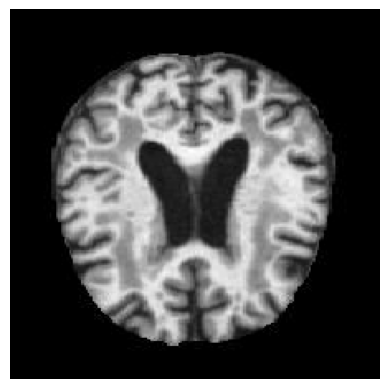

In [62]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('C:/Users/Ishani Dixit/Downloads/suyash/Alzheimer_Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
#probability = round(np.max(model.predict_proba(img)*100),2)

#print(probability, '% chances are there that the image is',idc[answer[0]])

d = dict(np.ndenumerate(answer))
print(d)

Keymax = max(d, key= lambda x: d[x])
print(Keymax)

print(idc[int(Keymax[1])])

Conclusion:

So, we have finally built are deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.

In [63]:
model.save("densenet.h5")